In [5]:
cd /mmfs1/data/aglinska/BC-fMRI-AE/Notebooks/

/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks


In [78]:
import numpy as np
import pandas as pd 
import pickle
from helper_funcs import *
from umap import UMAP

from matplotlib import pyplot as plt
import seaborn as sns

In [13]:
# LOAD LATENT DATA
data = pickle.load(open('../Data/latent_vecs/latent_vecs_CVAE_2021-09-15 14:03:53.826090','rb'))

In [44]:
# LOAD DF
df = pd.read_csv('../Data/ABIDE_df.csv')
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
patients = df['DX_GROUP'].values==1
len(df)

1048

In [12]:
print(data[list(data.keys())[0]].shape)
print(data['subs'].shape)

(10, 1048, 16)
(1048,)


In [34]:
# ASSERTS 
nsubs = len(df)
assert len(df['bids_folder'].values)==len(data['subs']), 'diff lenghts'
assert all([df['bids_folder'].values[s]==data['subs'][s] for s in range(nsubs)]), 'out of order'

In [106]:
# Make CMAT

asd_vec_bg = data['BG_ABIDE'][:,patients,:]
asd_vec_sl = data['SL_ABIDE'][:,patients,:]

asd_cmat_bg = np.array([make_RDM(data['BG_ABIDE'][i,patients,:],metric='correlation') for i in range(10)])
asd_cmat_sl = np.array([make_RDM(data['SL_ABIDE'][i,patients,:],metric='correlation') for i in range(10)])

In [107]:
asd_umap_bg = UMAP(n_components=2).fit_transform(asd_vec_bg[0,:,:])
asd_umap_sl = UMAP(n_components=2).fit_transform(asd_vec_sl[0,:,:])

In [115]:
#np.corrcoef(get_triu(asd_cmat_bg[1,:,:]),get_triu(asd_cmat_bg[0,:,:]))[0,1]

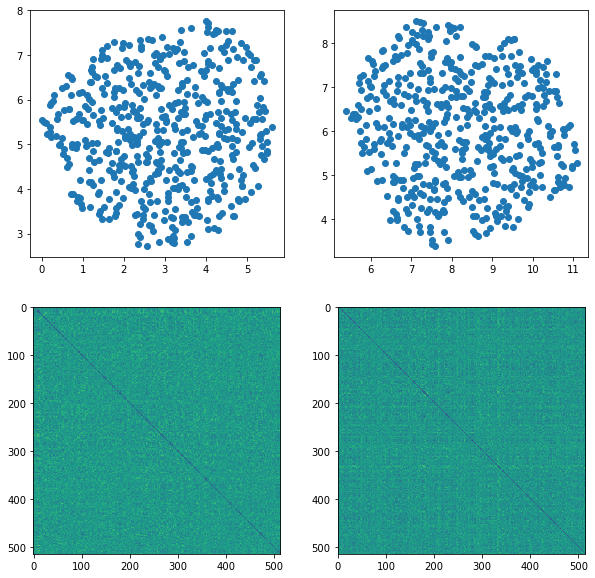

In [109]:
plt.figure(figsize=np.array((5,5))*2    )
plt.subplot(2,2,1)
plt.scatter(asd_umap_bg[:,0],asd_umap_bg[:,1])

plt.subplot(2,2,2)
plt.scatter(asd_umap_sl[:,0],asd_umap_sl[:,1])


plt.subplot(2,2,3)
#plt.scatter(asd_umap_bg[:,0],asd_umap_bg[:,1])
plt.imshow(asd_cmat_bg[0,:,:])

plt.subplot(2,2,4)
plt.imshow(asd_cmat_sl[0,:,:])